# DRAEM

 Bu notebook'ta, ahşap yüzeylerdeki anomalileri tespit etmek için bir *DRAEM* modeli geliştirilecek ve eğitilecektir.

## 1. Ortam Kurulumu

### 1.1 Google Drive Bağlantısı


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


### 1.2 DRAEM Deposunun Klonlanması

In [4]:
!git clone https://github.com/gmzdag/wood-anomaly-detection.git

fatal: destination path 'wood-anomaly-detection' already exists and is not an empty directory.


In [5]:
%cd /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/

/content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src


### 1.3 Gerekli Kütüphanelerin Kurulumu

In [6]:
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 41.3 MB/s eta 0:00:00


In [7]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 113.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## 2. Model Ağırlıklarının ve Veri Setlerinin Hazırlanması

DRAEM modeli için önceden eğitilmiş kontrol noktalarını (checkpoint) indirecek ve anomali üretimi için kullanılacak DTD (Daha Fazla Dokulu Sözlük) veri setini hazırlanması.


In [8]:
!mkdir checkpoints
%cd checkpoints
!pip install gdown
!gdown https://drive.google.com/uc?id=1eOE8wXNihjsiDvDANHFbg_mQkLesDrs1
!unzip DRAEM_checkpoints.zip

/content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/checkpoints
Downloading...
From (original): https://drive.google.com/uc?id=1eOE8wXNihjsiDvDANHFbg_mQkLesDrs1
From (redirected): https://drive.google.com/uc?id=1eOE8wXNihjsiDvDANHFbg_mQkLesDrs1&confirm=t&uuid=63a15fd9-5d75-4761-8c77-c4c9a461f32a
To: /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/checkpoints/DRAEM_checkpoints.zip
100% 5.43G/5.43G [02:08<00:00, 42.2MB/s]
Archive:  DRAEM_checkpoints.zip
   creating: DRAEM_checkpoints/
  inflating: DRAEM_checkpoints/DRAEM_seg_large_ae_large_0.0001_800_bs8_bottle_.pckl  
  inflating: DRAEM_checkpoints/DRAEM_seg_large_ae_large_0.0001_800_bs8_bottle__seg.pckl  
  inflating: DRAEM_checkpoints/DRAEM_seg_large_ae_large_0.0001_800_bs8_cable_.pckl  
  inflating: DRAEM_checkpoints/DRAEM_seg_large_ae_large_0.0001_800_bs8_cable__seg.pckl  
  inflating: DRAEM_checkpoints/DRAEM_seg_large_ae_large_0.0001_800_bs8_capsule_.pckl  
  inflating: DRAEM_checkpoints/DRAEM_seg_large_ae

In [9]:
%cd ..

/content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src


In [10]:
!mkdir datasets
%cd datasets
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar -xf dtd-r1.0.1.tar.gz
!rm dtd-r1.0.1.tar.gz

/content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/datasets
--2025-05-17 15:08:29--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz [following]
--2025-05-17 15:08:30--  https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  18.5MB/s    in 37s     

2025-05-17 15:09:08 (16.1 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



In [11]:
%cd ..

/content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src


## 3. Model Eğitimi

DRAEM modelinin ahşap veri seti üzerinde eğitilmesi. Eğitim parametreleri komut satırı argümanları ile belirtilir.


**Parametre Açıklamaları:**
- `--gpu_id`: Kullanılacak GPU'nun ID'si.
- `--obj_id`: Eğitilecek obje sınıfının ID'si. (Ahşap için 14)
- `--lr`: Öğrenme oranı (learning rate).
- `--bs`: Batch boyutu (batch size).
- `--epochs`: Eğitim epoch sayısı.
- `--data_path`: Ahşap veri setinin yolu.
- `--anomaly_source_path`: Anomali üretimi için kullanılacak DTD veri setinin yolu.
- `--checkpoint_path`: Eğitim sırasında model ağırlıklarının kaydedileceği dizin.
- `--log_path`: Eğitim loglarının kaydedileceği dizin.
- `--visualize`: Eğitim sırasında görselleştirmelerin yapılıp yapılmayacağı.


In [20]:
!python train_DRAEM.py \
  --gpu_id 0 \
  --obj_id 14 \
  --lr 0.0001 \
  --bs 8 \
  --epochs 200 \
  --data_path /content/drive/MyDrive/processed_dataset/\
  --anomaly_source_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/datasets/dtd/images/\
  --checkpoint_path ./checkpoints/ \
  --log_path ./logs/\
  --visualize

2025-05-17 15:41:29.237323: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 15:41:29.254842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747496489.275966   11329 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747496489.282420   11329 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-17 15:41:29.304173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [25]:
!python train_DRAEM.py \
  --gpu_id 0 \
  --obj_id 14 \
  --lr 0.0001 \
  --bs 8 \
  --epochs 20 \
  --data_path /content/drive/MyDrive/processed_dataset/\
  --anomaly_source_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/datasets/dtd/images/\
  --checkpoint_path ./checkpoints/ \
  --log_path ./logs/\
  --visualize

2025-05-17 16:15:18.271806: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 16:15:18.289367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747498518.310552   30212 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747498518.317068   30212 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-17 16:15:18.338116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 4. Modelin Test Edilmesi

Eğitilen modelin performansını test edilmesi. Farklı epoch sayılarında eğitilmiş modelleri test etmek için `base_model_name` parametresi ayarlandı.
Bu model ise epoch sayısın değiştirilmesi ile oluşturuldu.

DRAEM_test_x_y_bs8 -> x learning rate'i temsil ederken y ise epoch sayısını belirtmektedir.

**Parametre Açıklamaları:**
- `--gpu_id`: Kullanılacak GPU'nun ID'si.
- `--base_model_name`: Test edilecek modelin adı. Bu genellikle öğrenme oranı, epoch sayısı ve batch boyutu gibi bilgileri içerir. Eğitim çıktılarında bu isim belirtilir.
- `--data_path`: Test veri setinizin yolu.
- `--checkpoint_path`: Model ağırlıklarının bulunduğu dizin.


### 4.1 Farklı Epoch Değerleri İle

#### 20 Epoch

In [ ]:
!python test_DRAEM.py \
  --gpu_id 0 \
  --base_model_name "DRAEM_test_0.0001_20_bs8" \
  --data_path /content/drive/MyDrive/processed_dataset/ \
  --checkpoint_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/checkpoints



Processing wood...

Results for wood:
AUC Image:  0.951
AP Image:   0.937
AUC Pixel:  0.769
AP Pixel:   0.247
F1 Score (Pixel): 0.260
IoU Score (Pixel): 0.150
F1 Score (Image): 0.855
IoU Score (Image): 0.747
Threshold: 0.200

Summary for DRAEM_test_0.0001_20_bs8_wood_
AUC Image mean:  0.951
AP Image mean:   0.937
AUC Pixel mean:  0.769
AP Pixel mean:   0.247
F1 Score (Pixel) mean:  0.260
IoU Score (Pixel) mean:  0.150
F1 Score (Image) mean:  0.855
IoU Score (Image) mean:  0.747
Average threshold: 0.200
Metrics visualization saved to ./metric_visualizations/
Detailed results written to ./outputs/


#### 50 Epoch

In [ ]:
!python test_DRAEM.py \
  --gpu_id 0 \
  --base_model_name "DRAEM_test_0.0001_50_bs8" \
  --data_path /content/drive/MyDrive/processed_dataset/ \
  --checkpoint_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/checkpoints



Processing wood...

Results for wood:
AUC Image:  0.925
AP Image:   0.901
AUC Pixel:  0.815
AP Pixel:   0.240
F1 Score (Pixel): 0.292
IoU Score (Pixel): 0.171
F1 Score (Image): 0.826
IoU Score (Image): 0.703
Threshold: 0.200

Summary for DRAEM_test_0.0001_50_bs8_wood_
AUC Image mean:  0.925
AP Image mean:   0.901
AUC Pixel mean:  0.815
AP Pixel mean:   0.240
F1 Score (Pixel) mean:  0.292
IoU Score (Pixel) mean:  0.171
F1 Score (Image) mean:  0.826
IoU Score (Image) mean:  0.703
Average threshold: 0.200
Metrics visualization saved to ./metric_visualizations/
Detailed results written to ./outputs/


#### 100 Epoch

In [ ]:
!python test_DRAEM.py \
  --gpu_id 0 \
  --base_model_name "DRAEM_test_0.0001_100_bs8" \
  --data_path /content/drive/MyDrive/processed_dataset/ \
  --checkpoint_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/checkpoints



Processing wood...

Results for wood:
AUC Image:  0.938
AP Image:   0.902
AUC Pixel:  0.800
AP Pixel:   0.217
F1 Score (Pixel): 0.310
IoU Score (Pixel): 0.183
F1 Score (Image): 0.877
IoU Score (Image): 0.782
Threshold: 0.200

Summary for DRAEM_test_0.0001_100_bs8_wood_
AUC Image mean:  0.938
AP Image mean:   0.902
AUC Pixel mean:  0.800
AP Pixel mean:   0.217
F1 Score (Pixel) mean:  0.310
IoU Score (Pixel) mean:  0.183
F1 Score (Image) mean:  0.877
IoU Score (Image) mean:  0.782
Average threshold: 0.200
Metrics visualization saved to ./metric_visualizations/
Detailed results written to ./outputs/


#### 200 Epoch

In [26]:
!python test_DRAEM.py \
  --gpu_id 0 \
  --base_model_name "DRAEM_test_0.0001_200_bs8" \
  --data_path /content/drive/MyDrive/processed_dataset/ \
  --checkpoint_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/checkpoints\
  --visualize_masks\
  --visualization_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/visualization/



Processing wood...

Results for wood:
AUC Image:  0.932
AP Image:   0.903
AUC Pixel:  0.820
AP Pixel:   0.232
F1 Score (Pixel): 0.346
IoU Score (Pixel): 0.209
F1 Score (Image): 0.877
IoU Score (Image): 0.782
Threshold: 0.200

Summary for DRAEM_test_0.0001_200_bs8_wood_
AUC Image mean:  0.932
AP Image mean:   0.903
AUC Pixel mean:  0.820
AP Pixel mean:   0.232
F1 Score (Pixel) mean:  0.346
IoU Score (Pixel) mean:  0.209
F1 Score (Image) mean:  0.877
IoU Score (Image) mean:  0.782
Average threshold: 0.200
Metrics visualization saved to ./metric_visualizations/
Detailed results written to ./outputs/


### 4.2 Farklı Learning Değerleri İle

In [ ]:
!python train_DRAEM.py \
  --gpu_id 0 \
  --obj_id 14 \
  --lr 5e-5 \
  --bs 8 \
  --epochs 20 \
  --data_path /content/drive/MyDrive/processed_dataset/\
  --anomaly_source_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/datasets/dtd/images/\
  --checkpoint_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/checkpoints \
  --log_path ./logs/\
  --visualize

2025-05-15 18:19:10.896613: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 18:19:10.914861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747333150.936723   13472 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747333150.943323   13472 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 18:19:10.965289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

#### 5e-05 Learning Rate

In [ ]:
!python test_DRAEM.py \
  --gpu_id 0 \
  --base_model_name "DRAEM_test_5e-05_20_bs8" \
  --data_path /content/drive/MyDrive/processed_dataset/ \
  --checkpoint_path /content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/checkpoints



Processing wood...

Results for wood:
AUC Image:  0.957
AP Image:   0.948
AUC Pixel:  0.828
AP Pixel:   0.251
F1 Score (Pixel): 0.186
IoU Score (Pixel): 0.102
F1 Score (Image): 0.776
IoU Score (Image): 0.634
Threshold: 0.200

Summary for DRAEM_test_5e-05_20_bs8_wood_
AUC Image mean:  0.957
AP Image mean:   0.948
AUC Pixel mean:  0.828
AP Pixel mean:   0.251
F1 Score (Pixel) mean:  0.186
IoU Score (Pixel) mean:  0.102
F1 Score (Image) mean:  0.776
IoU Score (Image) mean:  0.634
Average threshold: 0.200
Metrics visualization saved to ./metric_visualizations/
Detailed results written to ./outputs/


## 5. Veri Görselleştirme

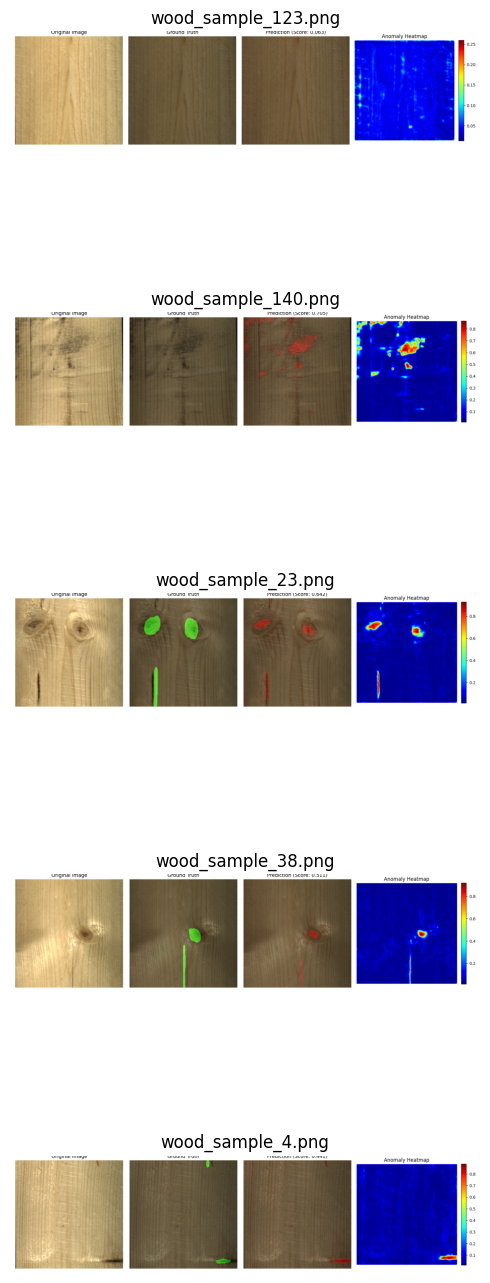

In [27]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_directory = 'visualization/wood/'

image_files = [f for f in os.listdir(image_directory) if f.endswith('.png')]
image_files.sort()

selected_images = image_files[:5]

fig, axes = plt.subplots(len(selected_images), 1, figsize=(5, 15))

for i, image_file in enumerate(selected_images):
    image_path = os.path.join(image_directory, image_file)

    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title(image_file)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
%cd ..

/content/drive/MyDrive
